# Grover's Search Algorithm

Classically, searching through an unstructured database, in the worst case will take O(N), queries. We can use quantum computers to speed up this process quadratically. It employs the amplitude amplification trick.

In [ ]:
!pip install 'qiskit[visualisation]'
!pip install qiskit
!pip install pylatexenc
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 KB 

In [ ]:
from qiskit.visualization.state_visualization import plot_bloch_multivector,plot_state_qsphere
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector,plot_state_city
from qiskit.quantum_info import Statevector,random_statevector
from qiskit.tools.visualization import circuit_drawer

In [ ]:
N = 7 #The number of qubits in the quantum circuit
circuit = QuantumCircuit(N,N)

## How to structure the search

In the database of N items, we will use n qubits to encode it so that we will have `2^n = N` items. In these set of items, we will have one winner item. On an average, classically we need to check `N/2` items. But with Grover's trick, we can do the same in `√N` queries. This speedup can be attributed to the fact that we utilise the superposition of all the items instead of the internal structure of the list. 

So, for the initialisation, we will take all the n qubits in `|0>` state and then apply Hadamard gates to them to bring them in a superposition of all the possible binary strings.

In [ ]:
def create_init_gate(nqubits):
  component = QuantumCircuit(nqubits,name="Init")

  for qubit in range(nqubits):
    component.h(qubit)

  return component.to_gate()

In [ ]:
circuit.append(create_init_gate(N),[i for i in range(N)]) # Mapping the gate onto the actual circuit's qubits

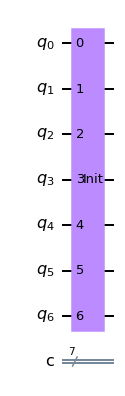

In [ ]:
circuit.draw(output='mpl')

## Oracle modelling

We want to create the phase Oracle in such a way that when we make a query, if the query input is the winner, then we will negate the amplitude of the winner in the superposition. This is represented in matrix form, by a diagonal matrix of all ones and a -1 for the winner column. 

We design the Oracle based on the binary strings that we want to find. In this case, for three qubits, let's say that we want to find the string `101` in this case, we will design the Oracle accordingly. For demonstration, we will create a general Oracle that will identify all the binary strings of the form `1(0+1)*1`, i.e, all the binary strings starting and ending with `1`.

In [ ]:
def create_oracle(nqubits):
  component = QuantumCircuit(nqubits,name="Oracle")

  component.cz(nqubits-1,0)

  return component.to_gate()

In [ ]:
circuit.append(create_oracle(N),[i for i in range(N)])

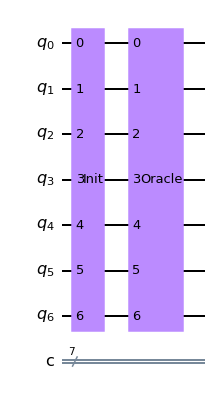

In [ ]:
circuit.draw('mpl')

## Amplitude Amplification

In the beginning, we have a uniform superposition, where the amplitudes of all the quantum states are the same. If there are `N` quantum states, then the amplitude of each quantum state it `1/N`. 

If we were to observe all the qubits, there is `1/N` chance that we will obtain the winner. Using the amplitude amplification trick, we can increase the probability of finding the winner. We can increase the probability to almost a hundred percent, so that we know if the winner exists in the superposition of the qubits. 

Geometrically speaking, we can decompose the superposition into two component, the winner component and the other qubits. After that we can follow the following steps to increase the probability of finding the winner:

1. Apply the Oracle reflection to the super position state `|s⟩`.
2. We will reflect the new state in the new axis about the state `|s⟩`.

We will repeat these steps `t` number of times, until we increase the amplitude. It turns out that mathematically `√N = t`. So the average time complexity is `√N`. 

In [ ]:
def create_multi_cz(nqubits):
  component = QuantumCircuit(nqubits)

  #Assuming that we are phase flipping the top qubit
  component.h(0)
  component.mcx([i+1 for i in range(nqubits-1)],0,mode='noancilla')
  component.h(0)

  return component.to_gate()

In [ ]:
def create_amplitude_amplifier(nqubits):
  component = QuantumCircuit(nqubits,name='Amplifier')

  #Initial layer of wrapping of Hadamard gates
  for qubit in range(nqubits):
    component.h(qubit)

  #Layer of wrapping of X gates
  for qubit in range(nqubits):
    component.x(qubit)
  
  #Applying the multi-controlled-Z gate for the phase flip
  component.append(create_multi_cz(N),[i for i in range(nqubits)])

  #Layer of wrapping of X gates
  for qubit in range(nqubits):
    component.x(qubit)

  #Since, we have assumed that we will flip the top qubit, we will apply the X, Z, X, Z gates to it
  component.x(0)
  component.z(0)
  component.x(0)
  component.z(0)

  #Layer of wrapping of H gates
  for qubit in range(nqubits):
    component.h(qubit)

  return component.to_gate()

In [ ]:
circuit.append(create_amplitude_amplifier(N),[i for i in range(N)])

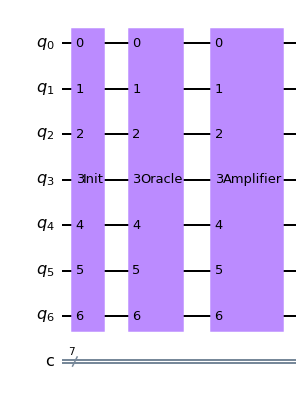

In [ ]:
circuit.draw('mpl')

In [ ]:
circuit.barrier()
circuit.measure([i for i in range(N)],[i for i in range(N)])

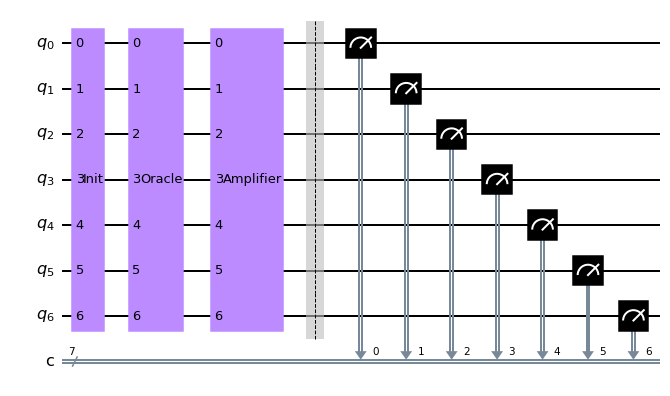

In [ ]:
circuit.draw('mpl')

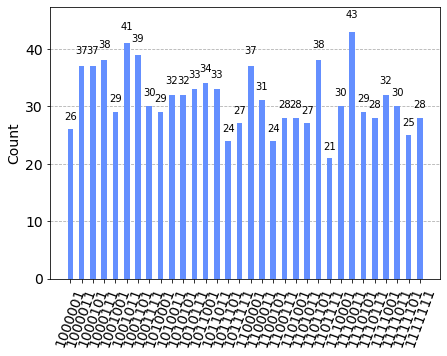

In [ ]:
#Now we will run the simulation for detecting the our required string in the superposition
SHOTS = 1000
simulator = QasmSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=SHOTS)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)

In [ ]:
#Table of probabilities
from tabulate import tabulate
table = tabulate([['String','Probability(in %)']]+[[k,v/SHOTS*100] for (k,v) in counts.items()],headers='firstrow',tablefmt='grid')
print(table)

+----------+---------------------+
|   String |   Probability(in %) |
+==========+=====================+
|  1111011 |                 3   |
+----------+---------------------+
|  1110101 |                 2.9 |
+----------+---------------------+
|  1000101 |                 3.7 |
+----------+---------------------+
|  1001011 |                 4.1 |
+----------+---------------------+
|  1010001 |                 2.9 |
+----------+---------------------+
|  1001111 |                 3   |
+----------+---------------------+
|  1110111 |                 2.8 |
+----------+---------------------+
|  1111001 |                 3.2 |
+----------+---------------------+
|  1010111 |                 3.3 |
+----------+---------------------+
|  1010011 |                 3.2 |
+----------+---------------------+
|  1011111 |                 2.7 |
+----------+---------------------+
|  1011011 |                 3.3 |
+----------+---------------------+
|  1100111 |                 2.8 |
+----------+--------

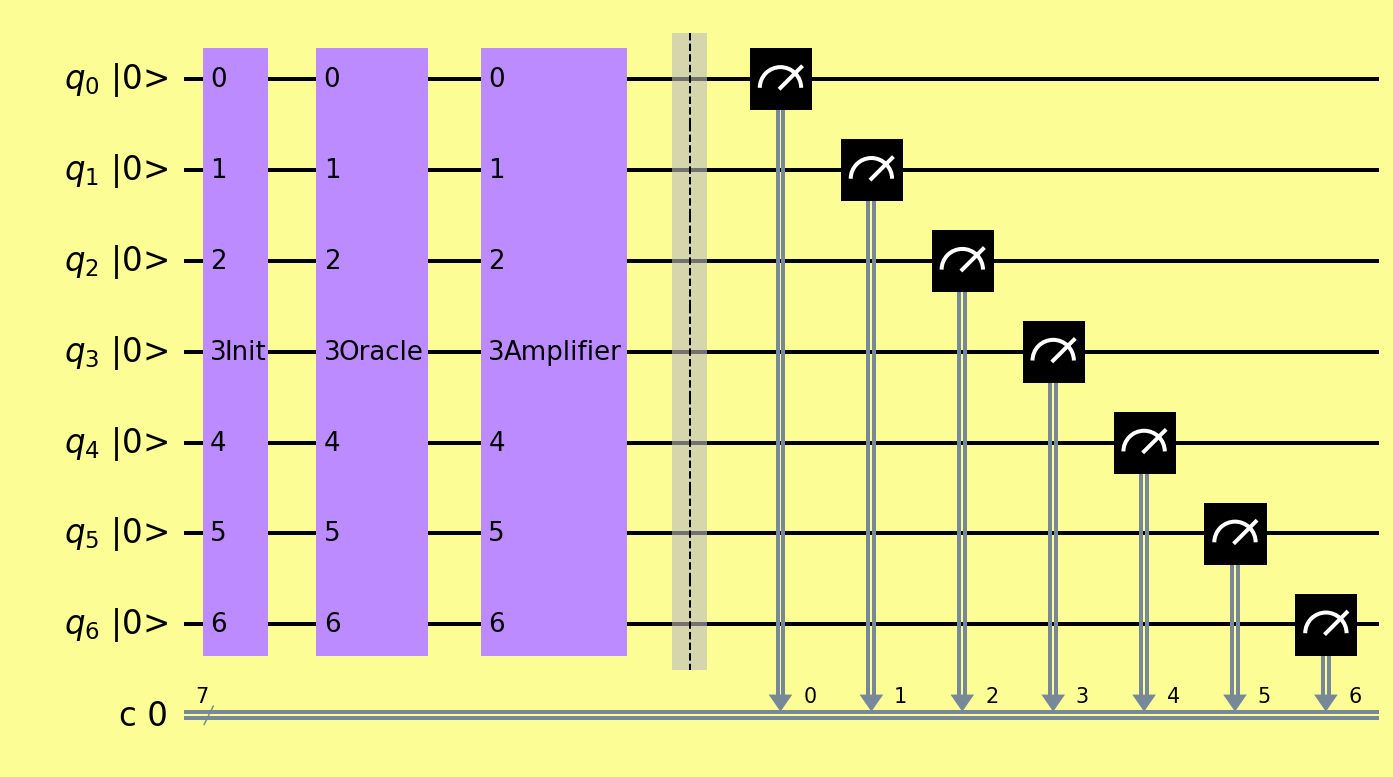

In [ ]:
#The final circuit
circuit_drawer(circuit,
               output='mpl',
               style={'backgroundcolor': '#fdfd96'},
               scale=2,
               justify='none',
               idle_wires=False,
               initial_state=True,
               cregbundle=True
               )